In [1]:
# %% [markdown]
# # Jupyter Notebook Loading Header
#
# This is a custom loading header for Jupyter Notebooks in Visual Studio Code.
# It includes common imports and settings to get you started quickly.

# %% [markdown]
## Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from google.cloud import bigquery
import os
path = r'C:\Users\DwaipayanChakroborti\AppData\Roaming\gcloud\legacy_credentials\dchakroborti@tonikbank.com\adc.json'
os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = path
client = bigquery.Client(project='prj-prod-dataplatform')

# %% [markdown]
## Configure Settings
# Set options or configurations as needed
pd.set_option('display.max_columns', None)

# Read the customer id from Raj CSV file

In [2]:
rajdf = pd.read_csv(r"C:\Users\DwaipayanChakroborti\OneDrive - Tonik Financial Pte Ltd\MyStuff\Biswa\Customer_360_Data_Prep\customerid_onboarded_1stJan2024.csv")

In [3]:
a = tuple(rajdf['customer_id'])
a[0:5]

(2355677, 2355517, 2355698, 2355673, 2355268)

# Education Type

In [4]:
sq = f"""
with
educate as 
(select distinct edu.digitalLoanAccountId, edu.education_id, edu1.description
from `prj-prod-dataplatform.dl_loans_db_raw.tdbk_loan_purpose` edu
inner join (select id, description from dl_loans_db_raw.tdbk_loan_lov_mtb where module = 'Education') edu1 on edu.education_id = edu1.id
),
educate2 as 
(select *, row_number() over(partition by digitalLoanAccountId order by education_id desc) rnk from educate),
educate3 as 
(select * from educate2 where rnk = 1)
select lmt.customerId,
educate3.education_id,
educate3.description Education_Type, 
educate3.rnk educationrnk
from educate3 
inner join prj-prod-dataplatform.risk_credit_mis.loan_master_table lmt on lmt.digitalLoanAccountId = educate3.digitalLoanAccountId
where lmt.customerId in {a}
"""
educationdf = client.query(sq).to_dataframe(progress_bar_type='tqdm')
educationdf


Job ID edd0f2c1-82ed-4365-8660-141c0c7eaa32 successfully executed: 100%|██████████|
Downloading: 100%|██████████|


,customerId,education_id,Education_Type,educationrnk
0,2355591,14,College Graduate,1
1,2355772,13,College Undergraduate,1
2,2355368,13,College Undergraduate,1
3,2355233,14,College Graduate,1
4,2355430,11,High School Graduate,1
...,...,...,...,...
91,2355351,13,College Undergraduate,1
92,2355517,12,Technical/Vocational Graduate,1
93,2355530,12,Technical/Vocational Graduate,1
94,2355517,13,College Undergraduate,1


# Telco Provider

In [5]:
sq = f"""
WITH ac_created AS 
(
  ## Base data of onboarded users
  SELECT DISTINCT 
  product,
  CASE 
    WHEN product = 'LOAN1.0' THEN 'Borrow'
    WHEN product = 'TSA1.0' THEN 'Save'
    WHEN product = 'TSAE1.0' THEN 'Explore'
    ELSE product END type,
  cust_id,
  user_id,
  device_id,
  created_dt,
  gender,
  mobile_no,
  birthplace,
  FROM prj-prod-dataplatform.dl_customers_db_raw.tdbk_customer_mtb
  WHERE 1=1
  AND cast(cust_id as numeric) in {a}
  AND created_dt >= '2023-06-01'
  ORDER BY 4
)
select 
    ac.cust_id,
    ac.user_id,
    ac.device_id,
    ac.created_dt,
    ac.gender,
    ac.birthplace,
    ac.mobile_no,
    ac.product,
    ac.type,
    t4.GeneralData.telephony_info__network_operator_name telcoProvider
from ac_created ac
inner join prj-prod-dataplatform.dl_loans_db_raw.tdbk_loan_customer_details tlcd on tlcd.custId = ac.cust_id  
inner JOIN `prj-prod-dataplatform.dl_loans_db_raw.tdbk_credolab_track` t3 ON cast(tlcd.credolabRefNumber as string) = cast(t3.refno as string)
left JOIN `prj-prod-dataplatform.credolab_raw.android_credolab_datasets_struct_columns` t4 ON t3.refno = t4.deviceId
where cast(ac.cust_id as numeric) in {a}
"""
clientdemodf1 = client.query(sq).to_dataframe(progress_bar_type='tqdm')

clientdemodf1.head()



Job ID baf3f05e-e8ab-44fd-a1bf-d158b02445f4 successfully executed: 100%|██████████|
Downloading: 100%|██████████|


,cust_id,user_id,device_id,created_dt,gender,birthplace,mobile_no,product,type,telcoProvider
0,2355369,8bb19a882f0b4a7a9d6f262dd912b503,9b9895a37f564fc3b0fd6e6271d98c77SHJcBsN3,2024-01-01 05:38:09+00:00,M,Manila,639275712231,TSAE1.0,Explore,GLOBE
1,2355615,5c5915e78cd6431cbf96454676de3d43,5a23a17ae4604ed2b67c41c9d7ff1f8dL5e97xOa,2024-01-01 10:49:29+00:00,F,Cotabato,639383677009,TSAE1.0,Explore,TNT
2,2355772,58afddc1c67b47339d6ab0b5e109cba2,640df8101828434f886f740519305f1bIKuEv3oz,2024-01-01 21:20:09+00:00,F,CABATUAN ILOILO,639560614570,TSAE1.0,Explore,GLOBE
3,2355664,032af04be667496ca119d4350f98c068,4bc9680f8cf34a27918ef03a22089fa7sZrOkSPa,2024-01-01 12:55:41+00:00,F,Marikina City,639051158587,TSA1.0,Save,None
4,2355454,4d335f5f39074e579368a84a81ec3d0a,5c53d1e351014773877d207440bb6f01ENRt7ElK,2024-01-01 07:32:43+00:00,F,Infanta Quezon,639307207445,TSAE1.0,Explore,None


# Merge Client Demo 1 with educationdf 

In [6]:
clientdemodf1['cust_id'] = clientdemodf1['cust_id'].astype(np.int64)

In [7]:
df = clientdemodf1.merge(educationdf, left_on='cust_id', right_on='customerId', how = 'left')
df.drop(columns=['customerId', 'educationrnk'], inplace = True)
df.head()

,cust_id,user_id,device_id,created_dt,gender,birthplace,mobile_no,product,type,telcoProvider,education_id,Education_Type
0,2355369,8bb19a882f0b4a7a9d6f262dd912b503,9b9895a37f564fc3b0fd6e6271d98c77SHJcBsN3,2024-01-01 05:38:09+00:00,M,Manila,639275712231,TSAE1.0,Explore,GLOBE,14,College Graduate
1,2355369,8bb19a882f0b4a7a9d6f262dd912b503,9b9895a37f564fc3b0fd6e6271d98c77SHJcBsN3,2024-01-01 05:38:09+00:00,M,Manila,639275712231,TSAE1.0,Explore,GLOBE,14,College Graduate
2,2355615,5c5915e78cd6431cbf96454676de3d43,5a23a17ae4604ed2b67c41c9d7ff1f8dL5e97xOa,2024-01-01 10:49:29+00:00,F,Cotabato,639383677009,TSAE1.0,Explore,TNT,13,College Undergraduate
3,2355615,5c5915e78cd6431cbf96454676de3d43,5a23a17ae4604ed2b67c41c9d7ff1f8dL5e97xOa,2024-01-01 10:49:29+00:00,F,Cotabato,639383677009,TSAE1.0,Explore,TNT,12,Technical/Vocational Graduate
4,2355772,58afddc1c67b47339d6ab0b5e109cba2,640df8101828434f886f740519305f1bIKuEv3oz,2024-01-01 21:20:09+00:00,F,CABATUAN ILOILO,639560614570,TSAE1.0,Explore,GLOBE,13,College Undergraduate


# Customer Details

In [8]:
sq = f"""    
SELECT 
  custid, dateOfBirth, 
  signUpAccNo, 
  kycStatus,
  addressline1, 
  city, 
  province, 
  barangay, 
  provinceCode, 
  postalcode, 
  mailingCity, 
  mailingPostalCode, 
  mailingProvince,
  natureofwork, 
  employmentstatus, 
  mobileOs, 
  docType, 
  onboardingDate, 
  created_dt, 
  ABS(TIMESTAMP_DIFF(
    PARSE_TIMESTAMP('%Y-%m-%d %H:%M:%E6S', onboardingDate),
    CAST(created_dt AS TIMESTAMP),
    MINUTE
  )) AS Minutestakentoonboard,
  companyName, 
  industry, 
  device_dtl,
FROM 
  `prj-prod-dataplatform.dl_loans_db_raw.tdbk_loan_customer_details`
WHERE 
  CAST(custId AS NUMERIC) IN {a}
"""
cddf = client.query(sq).to_dataframe(progress_bar_type='tqdm')
cddf.head()


Job ID c6485b4e-145a-4616-9dd0-fde6b6d6dc5b successfully executed: 100%|██████████|
Downloading: 100%|██████████|


,custid,dateOfBirth,signUpAccNo,kycStatus,addressline1,city,province,barangay,provinceCode,postalcode,mailingCity,mailingPostalCode,mailingProvince,natureofwork,employmentstatus,mobileOs,docType,onboardingDate,created_dt,Minutestakentoonboard,companyName,industry,device_dtl
0,2355236,24 Nov 2000,60823552360009,SKYC,781 ORANGE STREET,MABALACAT,Pampanga,SAN FRANCISCO,None,2010,MABALACAT,2010,Pampanga,16,1,None,Philippines - ePassport,2024-01-01 01:25:09.000000,2024-06-26 22:24:51,256139,Blue Solution Networks Phils Corp,9,None
1,2355688,18 May 1989,60823556880003,SKYC,480 Einstein Street Camella Homes,BACOOR,Cavite,REAL I,None,4102,None,None,None,9,1,ANDROID,Philippines - Professional Id Card,2024-01-01 14:11:04.000000,2024-01-03 03:43:52,2252,ISTA SOLUTIONS PERSONNEL,20,ANDROID-11
2,2355677,28 Dec 1981,60823556770001,SKYC,PUROK 2AAMPAYON BUTUAN CITY AGUSAN DEL NORTE P...,BUTUAN CITY,Agusan del Norte,AMPAYON,None,8600,CITY OF PASIG,1600,METRO MANILA,28,1,Android,Philippines - UMID Card,2024-01-01 13:41:54.000000,2024-01-01 13:49:20,7,"National Economic & Development Authority""",2,None
3,2355427,19 Aug 2000,60823554270004,SKYC,DOUBLE R RESORT SAN MIGUEL CITY OF TARLAC T...,SAN MIGUEL,Tarlac,SAN MIGUEL,None,2301,TARLAC CITY,2300,Tarlac,6,1,Android,Philippines - Id Card (2020),2024-01-01 06:46:10.000000,2024-01-01 06:48:35,2,Cloudworkers,38,None
4,2355776,15 Aug 1996,60823557760002,SKYC,BLK 32 LOT 2 CELINA HOMES 2 BRGY 168 CALOOCAN...,CITY OF CALOOCAN,METRO MANILA,KAYBIGA DEPARO,None,1420,CITY OF CALOOCAN,1420,METRO MANILA,41,1,None,Philippines - UMID Card (2016),2024-01-01 22:10:05.000000,2024-01-01 22:19:37,9,None,7,None


In [9]:
cddf['custid'] = cddf['custid'].astype(np.int64)
cddf.rename(columns={'custid':'cust_id'}, inplace=True)
cddf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 84 entries, 0 to 83
Data columns (total 23 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   cust_id                84 non-null     int64         
 1   dateOfBirth            84 non-null     object        
 2   signUpAccNo            80 non-null     object        
 3   kycStatus              84 non-null     object        
 4   addressline1           84 non-null     object        
 5   city                   84 non-null     object        
 6   province               84 non-null     object        
 7   barangay               84 non-null     object        
 8   provinceCode           0 non-null      object        
 9   postalcode             84 non-null     object        
 10  mailingCity            6 non-null      object        
 11  mailingPostalCode      6 non-null      object        
 12  mailingProvince        6 non-null      object        
 13  natureo

In [10]:
df = df.merge(cddf, on='cust_id', how = 'left')
df.columns

Index(['cust_id', 'user_id', 'device_id', 'created_dt_x', 'gender',
       'birthplace', 'mobile_no', 'product', 'type', 'telcoProvider',
       'education_id', 'Education_Type', 'dateOfBirth', 'signUpAccNo',
       'kycStatus', 'addressline1', 'city', 'province', 'barangay',
       'provinceCode', 'postalcode', 'mailingCity', 'mailingPostalCode',
       'mailingProvince', 'natureofwork', 'employmentstatus', 'mobileOs',
       'docType', 'onboardingDate', 'created_dt_y', 'Minutestakentoonboard',
       'companyName', 'industry', 'device_dtl'],
      dtype='object')

In [11]:
df.drop(columns=['created_dt_y'], inplace=True)
df.rename(columns={'created_dt_x':'created_dt'}, inplace = True)


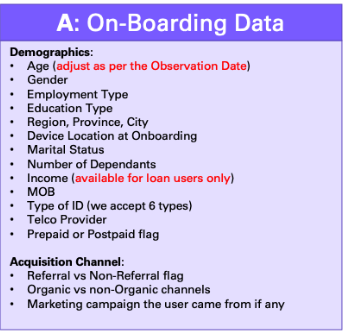

In [12]:
df.columns

Index(['cust_id', 'user_id', 'device_id', 'created_dt', 'gender', 'birthplace',
       'mobile_no', 'product', 'type', 'telcoProvider', 'education_id',
       'Education_Type', 'dateOfBirth', 'signUpAccNo', 'kycStatus',
       'addressline1', 'city', 'province', 'barangay', 'provinceCode',
       'postalcode', 'mailingCity', 'mailingPostalCode', 'mailingProvince',
       'natureofwork', 'employmentstatus', 'mobileOs', 'docType',
       'onboardingDate', 'Minutestakentoonboard', 'companyName', 'industry',
       'device_dtl'],
      dtype='object')

In [13]:
%%writefile age_calculator.py
from datetime import datetime
import pandas as pd

def calculate_age_in_days(date_of_birth):
    # Parse the date of birth
    dob = datetime.strptime(date_of_birth, "%d %b %Y")
    
    # Get the current date
    current_date = datetime.now()
    
    # Calculate the difference
    age_days = (current_date - dob).days
    
    return age_days

def add_age_column(df, date_column='dateOfBirth', new_column='AgeInDays'):
    # Apply the calculate_age_in_days function to the date column
    df[new_column] = df[date_column].apply(calculate_age_in_days)
    return df

Overwriting age_calculator.py


In [14]:
from age_calculator import calculate_age_in_days

# Add AgeInYears column (approximate)
df['Age'] = df['dateOfBirth'].apply(calculate_age_in_days)
df['Age'] = df['Age'] //365

# Region

In [15]:
sq = f"""
Select distinct 
  a.user_id,
  cast(a.cust_Id as numeric) cust_id,
  hm_postalcode,
  hm_barangay,
  hm_city,
  hm_province,
    CASE
    WHEN hm_province = 'KALINGA' THEN 'CAR – Cordillera Administrative Region'
    WHEN hm_province = 'OCCIDENTAL MINDORO' THEN 'MIMAROPA Region'
    WHEN hm_province = 'ORIENTAL MINDORO' THEN  'MIMAROPA Region'
    WHEN hm_province = 'ORODNIM' THEN 'MIMAROPA Region'
    WHEN hm_province = 'SAMAR (WESTERN SAMAR)' THEN 'Region VIII – Eastern Visayas'
    WHEN hm_province = 'ZAMBOANGA SIBUGAY' THEN 'Region IX – Zamboanga Peninsula'
    ELSE Region_name END Region_Name 
FROM prj-prod-dataplatform.dl_customers_db_raw.tdbk_customer_mtb a
LEFT JOIN prj-prod-dataplatform.dl_customers_db_raw.tdbk_customer_add_mtb f ON a.user_id = f.user_id
LEFT JOIN prj-prod-dataplatform.dap_ds_poweruser_playground.region_mappings h ON LOWER(f.hm_province) = LOWER(h.province)
where cast(a.cust_Id as numeric) in {a}
;
"""

regiondf = client.query(sq).to_dataframe(progress_bar_type = 'tqdm')

Job ID 51794b2d-ce0f-47c4-8ccf-bf751c57a3d1 successfully executed: 100%|██████████|
Downloading: 100%|██████████|


In [16]:
regiondf = regiondf[['cust_id', 'hm_postalcode', 'hm_barangay', 'hm_city',
       'hm_province', 'Region_Name']].copy()

In [17]:
regiondf['cust_id'] = regiondf['cust_id'].astype(np.int64)
regiondf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119 entries, 0 to 118
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   cust_id        119 non-null    int64 
 1   hm_postalcode  119 non-null    object
 2   hm_barangay    119 non-null    object
 3   hm_city        119 non-null    object
 4   hm_province    119 non-null    object
 5   Region_Name    119 non-null    object
dtypes: int64(1), object(5)
memory usage: 5.7+ KB


In [18]:
df = df.merge(regiondf, on='cust_id', how = 'left')

In [19]:
# List of columns to check and their corresponding 'hm_' columns
columns_to_check = [
    ('city', 'hm_city'),
    ('province', 'hm_province'),
    ('barangay', 'hm_barangay'),
    ('postalcode', 'hm_postalcode')
]

# Loop through the columns and replace null values
for col, hm_col in columns_to_check:
    df[col] = df[col].fillna(df[hm_col])

In [20]:
df.drop(columns = ['hm_postalcode', 'hm_barangay', 'hm_city',
       'hm_province'], inplace = True)

In [21]:
df.columns

Index(['cust_id', 'user_id', 'device_id', 'created_dt', 'gender', 'birthplace',
       'mobile_no', 'product', 'type', 'telcoProvider', 'education_id',
       'Education_Type', 'dateOfBirth', 'signUpAccNo', 'kycStatus',
       'addressline1', 'city', 'province', 'barangay', 'provinceCode',
       'postalcode', 'mailingCity', 'mailingPostalCode', 'mailingProvince',
       'natureofwork', 'employmentstatus', 'mobileOs', 'docType',
       'onboardingDate', 'Minutestakentoonboard', 'companyName', 'industry',
       'device_dtl', 'Age', 'Region_Name'],
      dtype='object')

# Device Location at Onboarding

In [22]:
sq =f"""SELECT 
  customer_id, 
  CASE WHEN event_description = 'Onboarding' THEN latitude END AS Onboarding_latitude,
  CASE WHEN event_description = 'Onboarding' THEN longitude END AS Onboarding_longitude,
  CASE WHEN event_description = 'Loan Journey' THEN latitude END AS loanjourney_latitude,
  CASE WHEN event_description = 'Loan Journey' THEN longitude END AS loanjouney_longitude,
  CASE WHEN event_description = 'Apigee Logs' THEN latitude END AS ApigeeLogs_latitude,
  CASE WHEN event_description = 'Apigee Logs' THEN longitude END AS ApigeeLogs_longitude
FROM `prj-prod-dataplatform.risk_mart.customer_gps_location`
where cast(customer_id as numeric) in {a}
QUALIFY ROW_NUMBER() OVER (PARTITION BY customer_id ORDER BY gps_collection_date DESC) = 1
;
"""

locationdf = client.query(sq).to_dataframe(progress_bar_type = 'tqdm')
locationdf.head()

Job ID 969fcaaf-0865-4f4a-88e6-8889af0f9dc2 successfully executed: 100%|██████████|
Downloading: 100%|██████████|


,customer_id,Onboarding_latitude,Onboarding_longitude,loanjourney_latitude,loanjouney_longitude,ApigeeLogs_latitude,ApigeeLogs_longitude
0,2355558,None,None,None,None,undefined,undefined
1,2355268,None,None,None,None,14.5579993,121.0433129
2,2355447,undefined,undefined,None,None,None,None
3,2355233,None,None,None,None,14.531075966523916,121.05369496173796
4,2355337,None,None,None,None,14.793780220157576,121.07393448885101


In [23]:
locationdf = locationdf.rename(columns={'customer_id': 'cust_id'}).astype({'cust_id': np.int64})

locationdf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119 entries, 0 to 118
Data columns (total 7 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   cust_id               119 non-null    int64 
 1   Onboarding_latitude   6 non-null      object
 2   Onboarding_longitude  6 non-null      object
 3   loanjourney_latitude  2 non-null      object
 4   loanjouney_longitude  2 non-null      object
 5   ApigeeLogs_latitude   111 non-null    object
 6   ApigeeLogs_longitude  111 non-null    object
dtypes: int64(1), object(6)
memory usage: 6.6+ KB


In [24]:
df = df.merge(locationdf, on = 'cust_id', how = 'left')
df.head()

,cust_id,user_id,device_id,created_dt,gender,birthplace,mobile_no,product,type,telcoProvider,education_id,Education_Type,dateOfBirth,signUpAccNo,kycStatus,addressline1,city,province,barangay,provinceCode,postalcode,mailingCity,mailingPostalCode,mailingProvince,natureofwork,employmentstatus,mobileOs,docType,onboardingDate,Minutestakentoonboard,companyName,industry,device_dtl,Age,Region_Name,Onboarding_latitude,Onboarding_longitude,loanjourney_latitude,loanjouney_longitude,ApigeeLogs_latitude,ApigeeLogs_longitude
0,2355369,8bb19a882f0b4a7a9d6f262dd912b503,9b9895a37f564fc3b0fd6e6271d98c77SHJcBsN3,2024-01-01 05:38:09+00:00,M,Manila,639275712231,TSAE1.0,Explore,GLOBE,14,College Graduate,13 Aug 1989,60823553690001,SKYC,RD6 EXT SITIO SIWANG FLOODWAY,TAYTAY,Rizal,SAN JUAN,None,1920,None,None,None,6,1,ANDROID,Philippines - Driving License (2017) #2,2024-01-01 05:38:09.000000,4,Telephilippines incorporated,8,ANDROID-13,35,Region IV-A – CALABARZON,None,None,None,None,14.5449481,121.11836
1,2355369,8bb19a882f0b4a7a9d6f262dd912b503,9b9895a37f564fc3b0fd6e6271d98c77SHJcBsN3,2024-01-01 05:38:09+00:00,M,Manila,639275712231,TSAE1.0,Explore,GLOBE,14,College Graduate,13 Aug 1989,60823553690001,SKYC,RD6 EXT SITIO SIWANG FLOODWAY,TAYTAY,Rizal,SAN JUAN,None,1920,None,None,None,6,1,ANDROID,Philippines - Driving License (2017) #2,2024-01-01 05:38:09.000000,4,Telephilippines incorporated,8,ANDROID-13,35,Region IV-A – CALABARZON,None,None,None,None,14.5449481,121.11836
2,2355615,5c5915e78cd6431cbf96454676de3d43,5a23a17ae4604ed2b67c41c9d7ff1f8dL5e97xOa,2024-01-01 10:49:29+00:00,F,Cotabato,639383677009,TSAE1.0,Explore,TNT,13,College Undergraduate,06 Mar 1995,60823556150006,SKYC,49ANTIPOLO ST BRGY 10 ZONE 4 1300 PASAY CITY NCR,PASAY CITY,METRO MANILA,BARANGAY 10,None,1300,None,None,None,9,1,Android,Philippines - Postal Id Card,2024-01-01 10:49:29.000000,5,zennya partnership,20,ANDROID-10,29,NCR – National Capital Region,None,None,None,None,undefined,undefined
3,2355615,5c5915e78cd6431cbf96454676de3d43,5a23a17ae4604ed2b67c41c9d7ff1f8dL5e97xOa,2024-01-01 10:49:29+00:00,F,Cotabato,639383677009,TSAE1.0,Explore,TNT,12,Technical/Vocational Graduate,06 Mar 1995,60823556150006,SKYC,49ANTIPOLO ST BRGY 10 ZONE 4 1300 PASAY CITY NCR,PASAY CITY,METRO MANILA,BARANGAY 10,None,1300,None,None,None,9,1,Android,Philippines - Postal Id Card,2024-01-01 10:49:29.000000,5,zennya partnership,20,ANDROID-10,29,NCR – National Capital Region,None,None,None,None,undefined,undefined
4,2355772,58afddc1c67b47339d6ab0b5e109cba2,640df8101828434f886f740519305f1bIKuEv3oz,2024-01-01 21:20:09+00:00,F,CABATUAN ILOILO,639560614570,TSAE1.0,Explore,GLOBE,13,College Undergraduate,02 Sep 1988,60823557720008,SKYC,PAMURINGAO PROPER CABATUAN ILOILO PROVINCE PHL...,CABATUAN,Iloilo,PAMURINGAO PROPER,None,5031,None,None,None,6,1,ANDROID,Philippines - UMID Card,2024-01-01 21:20:09.000000,2,Concentrix,8,ANDROID-14,36,Region VI – Western Visayas,None,None,None,None,14.6583352,121.1331128


# Marital Status, No. of Dependents, income

In [25]:
sq = f"""  
select 
customerId,
maritalStatus,
dependentsCount, 
monthlyIncome,
startApplyDateTime,
from
prj-prod-dataplatform.risk_credit_mis.loan_master_table
where (maritalStatus is not null or dependentsCount is not null or monthlyIncome is not null)
and customerId in {a}
qualify row_number() over (partition by customerId order by startApplyDateTime desc) = 1
;
"""
loandf = client.query(sq).to_dataframe(progress_bar_type = 'tqdm')
loandf.rename(columns={'customerId':'cust_id'}, inplace = True)
print(loandf.shape)
loandf.columns


Job ID 2df7af2a-a427-4f63-a35c-ef334f8cfe23 successfully executed: 100%|██████████|
Downloading: 100%|██████████|
(80, 5)


Index(['cust_id', 'maritalStatus', 'dependentsCount', 'monthlyIncome',
       'startApplyDateTime'],
      dtype='object')

In [26]:
df = df.merge(loandf, on = 'cust_id', how = 'left')

# Prepaid and PostPaid Flag

In [27]:
sq = f"""    
WITH ac_created AS 
(
  ## Base data of onboarded users
  SELECT DISTINCT 
  product,
  CASE 
    WHEN product = 'LOAN1.0' THEN 'Borrow'
    WHEN product = 'TSA1.0' THEN 'Save'
    WHEN product = 'TSAE1.0' THEN 'Explore'
    ELSE product END type,
  cust_id,
  user_id,
  device_id,
  created_dt,
  gender,
  mobile_no,
  FROM prj-prod-dataplatform.dl_customers_db_raw.tdbk_customer_mtb
  WHERE 1=1
  AND cast(cust_id as numeric) in {a}
  AND created_dt >= '2023-06-01'
  ORDER BY 4
)

, f_loan AS 
(
  ## First applied loan of a customer 
  SELECT DISTINCT customerId, new_loan_type, applicationStatus, disbursementdatetime, startApplydatetime
  FROM `risk_credit_mis.loan_master_table`
  WHERE 1=1
  AND customerId in {a}
  AND startApplyDatetime >= '2023-06-01'
  QUALIFY ROW_NUMBER() OVER (PARTITION BY customerId ORDER BY startApplyDatetime ASC) =1
)


, deposit_balance AS 
(
  ## Gets the balance of a customer on their 90th day upon account opening
    ## For the 1st condition of the balance of a customer upon the observation date
  SELECT DISTINCT a.ofdateopened,a.ofcustomerid, a.ofstandardaccountid,account_type,balanceDateAsOf, clearedbalance,
  FROM `prj-prod-dataplatform.core_raw.customer_accounts` a
  JOIN `risk_mart.customer_balance` b ON a.ofcustomerid = b.client_id AND a.ofstandardaccountid = b.accountid
  WHERE 1=1
  AND cast(a.ofcustomerid as numeric) in {a}
  -- AND clearedbalance >= 100
  -- AND ofcustomerid IN ('1514439','1252865','1248952')
  QUALIFY ROW_NUMBER() OVER (PARTITION BY ofcustomerid, ofstandardaccountid ORDER BY balancedateasof ASC) = 90
)

, af_link AS
(
  ## To get the AF ID and Customer ID Link (using the first install of a customer)
  SELECT DISTINCT customer_user_id, appsflyer_id, media_source, partner, campaign
  FROM `appsflyer_raw.organic_in_app_events_report`
  WHERE 1=1
  AND customer_user_id IS NOT NULL
  QUALIFY ROW_NUMBER() OVER (PARTITION BY customer_user_id ORDER BY install_time ASC) = 1
  
  UNION ALL
  
  SELECT DISTINCT customer_user_id, appsflyer_id, media_source, partner, campaign
  FROM `appsflyer_raw.in_app_events_report`
  WHERE 1=1
  AND customer_user_id IS NOT NULL
  QUALIFY ROW_NUMBER() OVER (PARTITION BY customer_user_id ORDER BY install_time ASC) = 1
)


, demog_details AS 
(
  ## Demographic Details
  SELECT DISTINCT
  a.user_id,
  a.cust_Id,
  a.device_id,
  b.id,
  c.description source_of_funds,
  d.description employment_status,
  monthly_income,
  hm_postalcode,
  hm_barangay,
  hm_city,
  hm_province,
  CASE
    WHEN hm_province = 'KALINGA' THEN 'CAR – Cordillera Administrative Region'
    WHEN hm_province = 'OCCIDENTAL MINDORO' THEN 'MIMAROPA Region'
    WHEN hm_province = 'ORIENTAL MINDORO' THEN  'MIMAROPA Region'
    WHEN hm_province = 'ORODNIM' THEN 'MIMAROPA Region'
    WHEN hm_province = 'SAMAR (WESTERN SAMAR)' THEN 'Region VIII – Eastern Visayas'
    WHEN hm_province = 'ZAMBOANGA SIBUGAY' THEN 'Region IX – Zamboanga Peninsula'
    ELSE Region_name END Region_Name
  FROM prj-prod-dataplatform.dl_customers_db_raw.tdbk_customer_mtb a
  LEFT JOIN prj-prod-dataplatform.dl_dynamo_db_raw.tdbk_regfinancial_profile1 b ON a.device_id = b.deviceId
  LEFT JOIN prj-prod-dataplatform.dl_dynamo_db_raw.tdbk_source_of_funds_mtb c ON b.sourceOfFundKey = c.id  
  LEFT JOIN prj-prod-dataplatform.dl_dynamo_db_raw.tdbk_employment_status_mtb d ON b.employmentStatusKey = d.id
  LEFT JOIN prj-prod-dataplatform.dl_customers_db_raw.tdbk_cust_profile_mtb e ON a.user_id = e.user_id
  LEFT JOIN prj-prod-dataplatform.dl_customers_db_raw.tdbk_customer_add_mtb f ON a.user_id = f.user_id
  LEFT JOIN prj-prod-dataplatform.dap_ds_poweruser_playground.region_mappings h ON LOWER(f.hm_province) = LOWER(h.province)
  where cast(a.cust_Id as numeric) in {a}
)


## Base query used to connect to other features 
SELECT DISTINCT
  a.created_dt registration_date,
  -- startApplyDateTime,
  -- ofdateopened,
  -- balancedateasof,
  a.cust_id,
  a.user_id,
  a.product,
  a.type,
  -- account_type,
  -- ofstandardaccountid,
  -- clearedbalance, 
  a.gender,
  customer_age,
  Region_Name,
  hm_province,
  hm_city,
  hm_barangay,
  hm_postalcode,
  source_of_funds,
  employment_status,
  CAST(monthly_income AS FLOAT64)*12.5 self_declared_annual_income,
  -- add the salary scale annual income
  -- double check if i can switch networks given the same number

  mobile_no,
  IFNULL(h.network_group,g.network_group) network_group,
  CASE
    WHEN g.network_group = 'Globe' AND h.network IS NULL THEN 'Prepaid'
    WHEN g.network_group = 'Globe' AND h.network IS NOT NULL THEN 'Postpaid'
    WHEN g.network_group = 'Smart' AND (LEFT(mobile_no,5) = '63920' OR LEFT(mobile_no,5) = '63918') THEN 'Postpaid'
    WHEN g.network_group NOT IN ('Globe','Smart') THEN NULL
    ELSE 'Prepaid' END network,
CASE 
  ### social media ###
  -- anything from social
  WHEN LOWER(COALESCE(Media_Source,Partner,Campaign)) LIKE '%social%' THEN 'Social'
  ### direct ###
  -- fwb / referral
  WHEN COALESCE(Media_Source,Partner,Campaign) = 'af_app_invites' THEN 'FWB'
  WHEN (Media_Source = 'invalid_media_source_name' OR Media_Source IS NULL) AND LOWER(Campaign) LIKE '%refer%' THEN 'FWB'
  WHEN LOWER(COALESCE(Media_Source,Partner,Campaign)) LIKE '%refer%' THEN 'FWB'
  WHEN LOWER(COALESCE(Media_Source,Partner,Campaign)) LIKE '%moengage%' THEN 'FWB'
  -- apple search
  WHEN LOWER(COALESCE(Media_Source,Partner,Campaign)) LIKE '%apple search ads%' THEN 'AppleSearch'
  -- facebook / meta
  WHEN COALESCE(Media_Source,Partner,Campaign) LIKE '%Facebook Ads%' THEN 'Ads_Meta'
  WHEN COALESCE(Media_Source,Partner,Campaign) LIKE '%meta%' THEN 'Ads_Meta'
  WHEN COALESCE(Media_Source,Partner,Campaign) = 'facebook' THEN 'Ads_Meta'
  WHEN LOWER(COALESCE(Media_Source,Partner,Campaign)) = 'restricted' THEN 'Ads_Meta'
  -- google
  WHEN COALESCE(Media_Source,Partner,Campaign) LIKE '%google%' THEN 'Ads_Google'
    -- tiktok
  WHEN COALESCE(Media_Source,Partner,Campaign) like '%bytedanceglobal%' THEN 'TikTok_Paid'
  ### affiliates ###
  -- pokkt source
  WHEN LOWER(COALESCE(Media_Source,Partner,Campaign)) LIKE '%pokkt%' THEN 'Aff_Pokkt'
  WHEN COALESCE(Media_Source,Partner,Campaign) LIKE '%Tonik_CPA%' THEN 'Aff_Pokkt'
  WHEN COALESCE(Media_Source,Partner,Campaign) LIKE '%campaign_name%' THEN 'Aff_Pokkt'
  -- tyr ads
  WHEN LOWER(COALESCE(Media_Source,Partner,Campaign)) IN ('tyrads_int','tjzymob_int','tyrads','ta_tonik_aos_ph') THEN 'Aff_TyrAds'
  -- sales doubler
  WHEN LOWER(COALESCE(Media_Source,Partner,Campaign)) LIKE '%salesdoubler%' THEN 'Aff_SalesDoubler'
  
  -- imoney
  WHEN COALESCE(Media_Source,Partner,Campaign) LIKE '%imoney%' THEN 'Aff_iMoney'
  -- moneymax
  WHEN COALESCE(Media_Source,Partner,Campaign) LIKE '%moneymax%' THEN 'Aff_MoneyMax'
  -- jeff
  WHEN COALESCE(Media_Source,Partner,Campaign) LIKE '%jeff%' THEN 'Aff_Jeff'
  -- shareit
  WHEN COALESCE(Media_Source,Partner,Campaign) LIKE '%shareit%' THEN 'Aff_ShareIt'
  
  -- appnext
  WHEN COALESCE(Media_Source,Partner,Campaign) LIKE '%appnext%' THEN 'Aff_AppNext'
  -- mediadonuts / entravision
  WHEN LOWER(COALESCE(Media_Source,Partner,Campaign)) LIKE '%mediadonuts%' THEN 'Aff_Mediadonuts'
  WHEN LOWER(COALESCE(Media_Source,Partner,Campaign)) LIKE '%entravision%' THEN 'Aff_Mediadonuts'
  -- shopback
  WHEN LOWER(COALESCE(Media_Source,Partner,Campaign)) LIKE '%shopback_int%' THEN 'Aff_Shopback'
  -- deepsea
  WHEN LOWER(COALESCE(Media_Source,Partner,Campaign)) LIKE '%deepsea%' THEN 'Aff_DeepSea'
  -- avow
  WHEN COALESCE(Media_Source,Partner,Campaign) LIKE '%avow%' THEN 'Aff_AvowTech'
  -- avow
  WHEN COALESCE(Media_Source,Partner,Campaign) LIKE '%vivo%' THEN 'Aff_Vivo'
  -- 711
  WHEN COALESCE(Media_Source,Partner,Campaign) LIKE '%SevenEleven%' THEN 'SevenEleven'
  ## organic ##
  WHEN COALESCE(Media_Source,Partner,Campaign) IN ('af_banner') THEN 'af_Banner'
  WHEN COALESCE(Media_Source,Partner,Campaign) LIKE '%sendgrid%' THEN 'Organic'
  WHEN COALESCE(Media_Source,Partner,Campaign) IN ('Website') THEN 'Website'
  
  ## owned media ##
  WHEN media_source IN ('PRFlexLoans_WebAndroidPressRelease') THEN 'Owned Media'
  
  WHEN media_source IN ('invalid_media_source_name') THEN 'Invalid Media Source'
  WHEN media_source IN ('None') THEN 'Broken OneLink'
  WHEN media_source IS NULL AND partner IS NULL AND campaign IS NULL THEN 'Organic'
  ELSE COALESCE(media_source,partner,campaign) END as Source,
  media_source,
  partner,
  campaign,
  
FROM ac_created a
LEFT JOIN f_loan b ON a.cust_id  = CAST(b.customerId AS STRING)
LEFT JOIN deposit_balance c ON a.cust_id = c.ofcustomerid
JOIN af_link d ON a.cust_id = d.customer_user_id
JOIN prj-prod-dataplatform.dl_customers_db_derived.Tdbk_customer_mtb_age_derived e ON a.cust_id = e.cust_id
LEFT JOIN demog_details f ON a.cust_id = f.cust_id
LEFT JOIN `prj-prod-dataplatform.manual_source_extracts.mobile_carrier_mapping` g
  ON LEFT(RIGHT(mobile_no,LENGTH(mobile_no)-2),3) = CAST(g.number_prefix AS STRING)
LEFT JOIN `prj-prod-dataplatform.manual_source_extracts.mobile_carrier_mapping` h 
  ON LEFT(RIGHT(mobile_no,LENGTH(mobile_no)-2),4) = CAST(h.number_prefix AS STRING)
WHERE 1=1
## The deposit account of a customer upon the 90th day is greater than 100 
AND clearedbalance >= 100

## The customer did not initiate any loan process within 90 days from account creation
AND (DATE_DIFF(DATE(startApplyDateTime),DATE(created_dt),DAY)>=90 OR b.customerid IS NULL)
AND c.ofcustomerid IS NOT NULL
AND cast( a.cust_id as numeric) in {a}
"""

demogdf2 = client.query(sq).to_dataframe(progress_bar_type = 'tqdm')
demogdf2.head()



Job ID ab544e0c-dbc7-4911-a44f-56c828e233e8 successfully executed: 100%|██████████|
Downloading: 100%|██████████|


,registration_date,cust_id,user_id,product,type,gender,customer_age,Region_Name,hm_province,hm_city,hm_barangay,hm_postalcode,source_of_funds,employment_status,self_declared_annual_income,mobile_no,network_group,network,Source,media_source,partner,campaign
0,2024-01-01 11:37:55+00:00,2355639,1bceac1dd40341d7aeef5cf09a1daf49,TSAE1.0,Explore,F,38,Region IV-A – CALABARZON,LAGUNA,SAN PEDRO,LANGGAM,4023,Salary,Employed,375000.0,639956386339,Globe,Prepaid,Organic,None,None,None
1,2024-01-01 19:22:44+00:00,2355761,c5f6f12be3104bef947978b2c3ddf009,TSAE1.0,Explore,M,32,NCR – National Capital Region,METRO MANILA,CITY OF CALOOCAN,BARANGAY 141,1400,None,None,12.5,639178114122,Globe,Postpaid,Organic,None,None,None
2,2024-01-01 18:05:03+00:00,2355747,ae164686f70244698b7362b43a668c1a,TSAE1.0,Explore,F,28,NCR – National Capital Region,METRO MANILA,QUEZON CITY,CENTRAL,1100,Salary,Employed,500000.0,639173286262,Globe,Postpaid,Organic,None,None,None
3,2024-01-01 23:58:20+00:00,2355794,38491888b57c4a1bbcf5390d375745e9,TSAE1.0,Explore,M,24,NCR – National Capital Region,METRO MANILA,QUEZON CITY,PASONG TAMO,1107,Salary,Employed,312500.0,639067351005,Globe,Prepaid,Organic,None,None,None
4,2024-01-01 14:11:04+00:00,2355688,d51b23e3e6e1438dbf96a14e11c9cad6,TSAE1.0,Explore,F,35,Region IV-A – CALABARZON,CAVITE,BACOOR,REAL I,4102,Salary,Employed,437500.0,639165968842,Globe,Prepaid,Organic,None,None,None


In [28]:
demogdf2.columns

demogdf2 = demogdf2[['cust_id', 'network_group', 'Source',	'media_source',	'partner','campaign']].copy()

In [29]:
demogdf2['cust_id'] = demogdf2['cust_id'].astype(np.int64)
demogdf2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33 entries, 0 to 32
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   cust_id        33 non-null     int64 
 1   network_group  33 non-null     object
 2   Source         33 non-null     object
 3   media_source   0 non-null      object
 4   partner        3 non-null      object
 5   campaign       3 non-null      object
dtypes: int64(1), object(5)
memory usage: 1.7+ KB


In [30]:
duplicate_ids = demogdf2[demogdf2['cust_id'].duplicated()]['cust_id']
duplicate_ids

21    2355298
28    2355673
29    2355366
Name: cust_id, dtype: int64

In [31]:
demogdf2[demogdf2['cust_id'] == 2355366]

,cust_id,network_group,Source,media_source,partner,campaign
23,2355366,Globe,Organic,None,None,None
29,2355366,Smart,Organic,None,None,None


In [32]:
demogdf2 = demogdf2.drop_duplicates(subset='cust_id', keep='first')

In [33]:
df = df.merge(demogdf2, on = 'cust_id', how='left')

# MOB

In [34]:
df.columns

Index(['cust_id', 'user_id', 'device_id', 'created_dt', 'gender', 'birthplace',
       'mobile_no', 'product', 'type', 'telcoProvider', 'education_id',
       'Education_Type', 'dateOfBirth', 'signUpAccNo', 'kycStatus',
       'addressline1', 'city', 'province', 'barangay', 'provinceCode',
       'postalcode', 'mailingCity', 'mailingPostalCode', 'mailingProvince',
       'natureofwork', 'employmentstatus', 'mobileOs', 'docType',
       'onboardingDate', 'Minutestakentoonboard', 'companyName', 'industry',
       'device_dtl', 'Age', 'Region_Name', 'Onboarding_latitude',
       'Onboarding_longitude', 'loanjourney_latitude', 'loanjouney_longitude',
       'ApigeeLogs_latitude', 'ApigeeLogs_longitude', 'maritalStatus',
       'dependentsCount', 'monthlyIncome', 'startApplyDateTime',
       'network_group', 'Source', 'media_source', 'partner', 'campaign'],
      dtype='object')

In [35]:
# Step 1: Convert columns to datetime datatype
df['onboardingDate'] = pd.to_datetime(df['onboardingDate'])
df['startApplyDateTime'] = pd.to_datetime(df['startApplyDateTime'])

# Step 2: Find the earliest date between onboardingDate and startApplyDateTime
df['earliest_date'] = df[['onboardingDate', 'startApplyDateTime']].min(axis=1)

# Step 3: Calculate the difference in months from the earliest date to current date
current_date = pd.Timestamp.now()
df['months_difference'] = (current_date - df['earliest_date']).dt.days / 30.44  # Average days in a month

# Round the result to 2 decimal places
df['months_difference'] = df['months_difference'].round(2)



In [36]:
df['DataSet'] = 'Demographic Data'

In [37]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 93 entries, 0 to 92
Data columns (total 53 columns):
 #   Column                 Non-Null Count  Dtype              
---  ------                 --------------  -----              
 0   cust_id                93 non-null     int64              
 1   user_id                93 non-null     object             
 2   device_id              93 non-null     object             
 3   created_dt             93 non-null     datetime64[us, UTC]
 4   gender                 93 non-null     object             
 5   birthplace             93 non-null     object             
 6   mobile_no              93 non-null     object             
 7   product                93 non-null     object             
 8   type                   93 non-null     object             
 9   telcoProvider          72 non-null     object             
 10  education_id           93 non-null     object             
 11  Education_Type         93 non-null     object             
 

In [38]:
df.head()

,cust_id,user_id,device_id,created_dt,gender,birthplace,mobile_no,product,type,telcoProvider,education_id,Education_Type,dateOfBirth,signUpAccNo,kycStatus,addressline1,city,province,barangay,provinceCode,postalcode,mailingCity,mailingPostalCode,mailingProvince,natureofwork,employmentstatus,mobileOs,docType,onboardingDate,Minutestakentoonboard,companyName,industry,device_dtl,Age,Region_Name,Onboarding_latitude,Onboarding_longitude,loanjourney_latitude,loanjouney_longitude,ApigeeLogs_latitude,ApigeeLogs_longitude,maritalStatus,dependentsCount,monthlyIncome,startApplyDateTime,network_group,Source,media_source,partner,campaign,earliest_date,months_difference,DataSet
0,2355369,8bb19a882f0b4a7a9d6f262dd912b503,9b9895a37f564fc3b0fd6e6271d98c77SHJcBsN3,2024-01-01 05:38:09+00:00,M,Manila,639275712231,TSAE1.0,Explore,GLOBE,14,College Graduate,13 Aug 1989,60823553690001,SKYC,RD6 EXT SITIO SIWANG FLOODWAY,TAYTAY,Rizal,SAN JUAN,None,1920,None,None,None,6,1,ANDROID,Philippines - Driving License (2017) #2,2024-01-01 05:38:09,4,Telephilippines incorporated,8,ANDROID-13,35,Region IV-A – CALABARZON,None,None,None,None,14.5449481,121.11836,Single,No dependents,25000,2024-06-06 11:16:48,NaN,NaN,NaN,NaN,NaN,2024-01-01 05:38:09,8.11,Demographic Data
1,2355369,8bb19a882f0b4a7a9d6f262dd912b503,9b9895a37f564fc3b0fd6e6271d98c77SHJcBsN3,2024-01-01 05:38:09+00:00,M,Manila,639275712231,TSAE1.0,Explore,GLOBE,14,College Graduate,13 Aug 1989,60823553690001,SKYC,RD6 EXT SITIO SIWANG FLOODWAY,TAYTAY,Rizal,SAN JUAN,None,1920,None,None,None,6,1,ANDROID,Philippines - Driving License (2017) #2,2024-01-01 05:38:09,4,Telephilippines incorporated,8,ANDROID-13,35,Region IV-A – CALABARZON,None,None,None,None,14.5449481,121.11836,Single,No dependents,25000,2024-06-06 11:16:48,NaN,NaN,NaN,NaN,NaN,2024-01-01 05:38:09,8.11,Demographic Data
2,2355615,5c5915e78cd6431cbf96454676de3d43,5a23a17ae4604ed2b67c41c9d7ff1f8dL5e97xOa,2024-01-01 10:49:29+00:00,F,Cotabato,639383677009,TSAE1.0,Explore,TNT,13,College Undergraduate,06 Mar 1995,60823556150006,SKYC,49ANTIPOLO ST BRGY 10 ZONE 4 1300 PASAY CITY NCR,PASAY CITY,METRO MANILA,BARANGAY 10,None,1300,None,None,None,9,1,Android,Philippines - Postal Id Card,2024-01-01 10:49:29,5,zennya partnership,20,ANDROID-10,29,NCR – National Capital Region,None,None,None,None,undefined,undefined,Single,2,25000,2024-07-11 11:19:12,NaN,NaN,NaN,NaN,NaN,2024-01-01 10:49:29,8.08,Demographic Data
3,2355615,5c5915e78cd6431cbf96454676de3d43,5a23a17ae4604ed2b67c41c9d7ff1f8dL5e97xOa,2024-01-01 10:49:29+00:00,F,Cotabato,639383677009,TSAE1.0,Explore,TNT,12,Technical/Vocational Graduate,06 Mar 1995,60823556150006,SKYC,49ANTIPOLO ST BRGY 10 ZONE 4 1300 PASAY CITY NCR,PASAY CITY,METRO MANILA,BARANGAY 10,None,1300,None,None,None,9,1,Android,Philippines - Postal Id Card,2024-01-01 10:49:29,5,zennya partnership,20,ANDROID-10,29,NCR – National Capital Region,None,None,None,None,undefined,undefined,Single,2,25000,2024-07-11 11:19:12,NaN,NaN,NaN,NaN,NaN,2024-01-01 10:49:29,8.08,Demographic Data
4,2355772,58afddc1c67b47339d6ab0b5e109cba2,640df8101828434f886f740519305f1bIKuEv3oz,2024-01-01 21:20:09+00:00,F,CABATUAN ILOILO,639560614570,TSAE1.0,Explore,GLOBE,13,College Undergraduate,02 Sep 1988,60823557720008,SKYC,PAMURINGAO PROPER CABATUAN ILOILO PROVINCE PHL...,CABATUAN,Iloilo,PAMURINGAO PROPER,None,5031,None,None,None,6,1,ANDROID,Philippines - UMID Card,2024-01-01 21:20:09,2,Concentrix,8,ANDROID-14,36,Region VI – Western Visayas,None,None,None,None,14.6583352,121.1331128,Single,No dependents,30000,2024-07-23 18:36:56,NaN,NaN,NaN,NaN,NaN,2024-01-01 21:20:09,8.08,Demographic Data


In [39]:
df.to_csv("B_Demographic_data.csv", index = False)

1.  **Age**                                 -   <span style="color: green;">Done</span>
2.  **Gender**                              -   <span style="color: green;">Done</span>
3.  **Education Type**                      -   <span style="color: green;">Done</span>
4.  **Region**                              -   <span style="color: green;">Done</span>
5.  **Province**                            -   <span style="color: green;">Done</span>
6.  **City**                                -   <span style="color: green;">Done</span>
7.  **Device Location at Onboarding**       -   <span style="color: green;">Done</span>
8.  **Marital Status**                      -   <span style="color: green;">Done</span>
9.  **Number of Dependents**                -   <span style="color: green;">Done</span>
10. **Income**                              -   <span style="color: green;">Done</span>
11. **MOB**                                 -   <span style="color: red;">Pending -- Calculate from Oboarding or StartApplyDateTime whichever is first</span>
12. **Type of ID**                          -   <span style="color: green;">Done</span>
13. **Telco Provider**                      -   <span style="color: green;">Done</span>
14. **Prepaid or Postpaid Flag**            -   <span style="color: green;">Done</span>

Aquisition Channel:

1.  **Referral vs Non-Referral Flag**               -   <span style="color: red;">Pending</span>  -- Need to check with Ivannah
2.  **Organic vs Non-Organic Channels**             -   <span style="color: green;">Done</span>
3.  **Marketing campaign the user came from if any**-   <span style="color: green;">Done</span>
